Calculate the Bayes Factor for the absolute magnitude using the `pocoMC` package to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import pocomc as pc

import matplotlib
import matplotlib.pyplot as plt

#from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
from functions import log_prior, bin_data, logLjoint1_skew, logLjoint2_skew, Model_1_fit, Model_2_fit, Model_1_plot, Model_2_plot

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

In [8]:
del catalog_main, catalog_north, data

# Fit the $M_r$ distributions with skewnormal distributions

Both one- and two-parent models

In [9]:
#rabsmag_bins = np.linspace(-25, -12.5, 170)
rabsmag_bins = np.arange(-24, -15, 0.1)

This is a unimodal distribution, but we are fitting it with a sum of two skew normals to account for the extra bumps in the distributions.

## 1-parent model

In [10]:
'''
V2_fit_bounds1 = [[0.1, 10],     # s ...... Gaussian 1 to 2 scale factor
                  [1000, 20000], # a ...... Gaussian amplitude
                  [-22, -18],    # mu ..... Gaussian location
                  [0.1, 3],      # sigma .. Gaussian scale
                  [0, 5]]        # skew ... Gaussian skew
'''
V2_fit_bounds1 = [[0.1, 10],     # s ........ Gaussian 1 to 2 scale factor
                  [1000, 50000], # a ........ Gaussian a amplitude
                  [-22, -20],    # mu_a ..... Gaussian a location
                  [1e-5, 2],     # sigma_a .. Gaussian a scale
                  [-5, 5],       # skew_a ... Gaussian a skew
                  [500, 50000],  # b ........ Gaussian b amplitude
                  [-20, -15],    # mu_b ..... Gaussian b location
                  [1e-5, 2],     # sigma_b .. Gaussian b scale
                  [-5, 5]]       # skew_b ... Gaussian b skew

'''
V2_rabsmag_bestfit1 = Model_1_fit(V2_fit_bounds1, 
                                  rabsmag_NSA[wall_v2], 
                                  rabsmag_NSA[void_v2], 
                                  rabsmag_bins, 
                                  2)

V2_rabsmag_bestfit1
''';

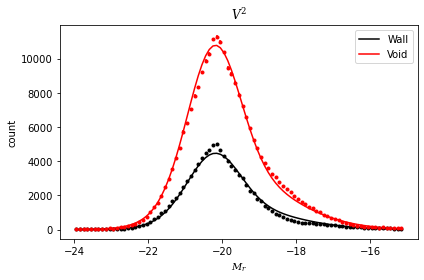

In [11]:
Model_1_plot(V2_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

In [11]:
VF_fit_bounds1 = [[0.1, 10],     # s ........ Gaussian 1 to 2 scale factor
                  [1000, 50000], # a ........ Gaussian a amplitude
                  [-22, -20],    # mu_a ..... Gaussian a location
                  [1e-5, 2],     # sigma_a .. Gaussian a scale
                  [-5, 5],       # skew_a ... Gaussian a skew
                  [500, 50000],  # b ........ Gaussian b amplitude
                  [-20, -15],    # mu_b ..... Gaussian b location
                  [1e-5, 2],     # sigma_b .. Gaussian b scale
                  [-5, 5]]       # skew_b ... Gaussian b skew
'''
VF_rabsmag_bestfit1 = Model_1_fit(VF_fit_bounds1, 
                                  rabsmag_NSA[wall_vf], 
                                  rabsmag_NSA[void_vf], 
                                  rabsmag_bins, 
                                  2)

VF_rabsmag_bestfit1
''';

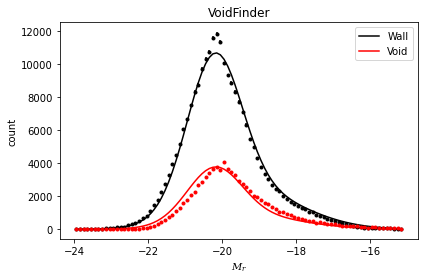

In [13]:
Model_1_plot(VF_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='VoidFinder')

### Nested sampling of Likelihood and Priors

In [ ]:
# Number of particles to use
n_particles = 1000

# Number of parameters in M1
n_dim1 = len(V2_fit_bounds1)

# Prior samples for M1
V2_prior_samples1 = np.random.uniform(low=np.array(V2_fit_bounds1).T[0], 
                                      high=np.array(V2_fit_bounds1).T[1], 
                                      size=(n_particles, n_dim1))

# Bin data
x, n1, n2, dn1, dn2 = bin_data(rabsmag_NSA[wall_v2], 
                               rabsmag_NSA[void_v2], 
                               rabsmag_bins)

# Initialize sampler for M1
V2_sampler1 = pc.Sampler(n_particles=n_particles, 
                         n_dim=n_dim1, 
                         log_likelihood=logLjoint1_skew, 
                         log_prior=log_prior, 
                         bounds=np.array(V2_fit_bounds1), 
                         log_likelihood_args=[n1, n2, x, 2], 
                         log_prior_args=[np.array(V2_fit_bounds1)])

# Run sampler
V2_sampler1.run(V2_prior_samples1)

Iter: 1it [00:00, 105.26it/s, beta=8.2e-8, calls=1000, ESS=0.95, logZ=-.35, accept=0.234, N=0, scale=1]

In [10]:
#temp_infile = open('dynesty_output/sampler_results_model1_gauss_rabsmag_V2.pickle', 'rb')
temp_infile = open('dynesty_output/sampler_results_model1_rabsmag_V2.pickle', 'rb')
dres1_V2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

In [11]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

In [12]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                    'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
               '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$', 
               '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
               '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$']

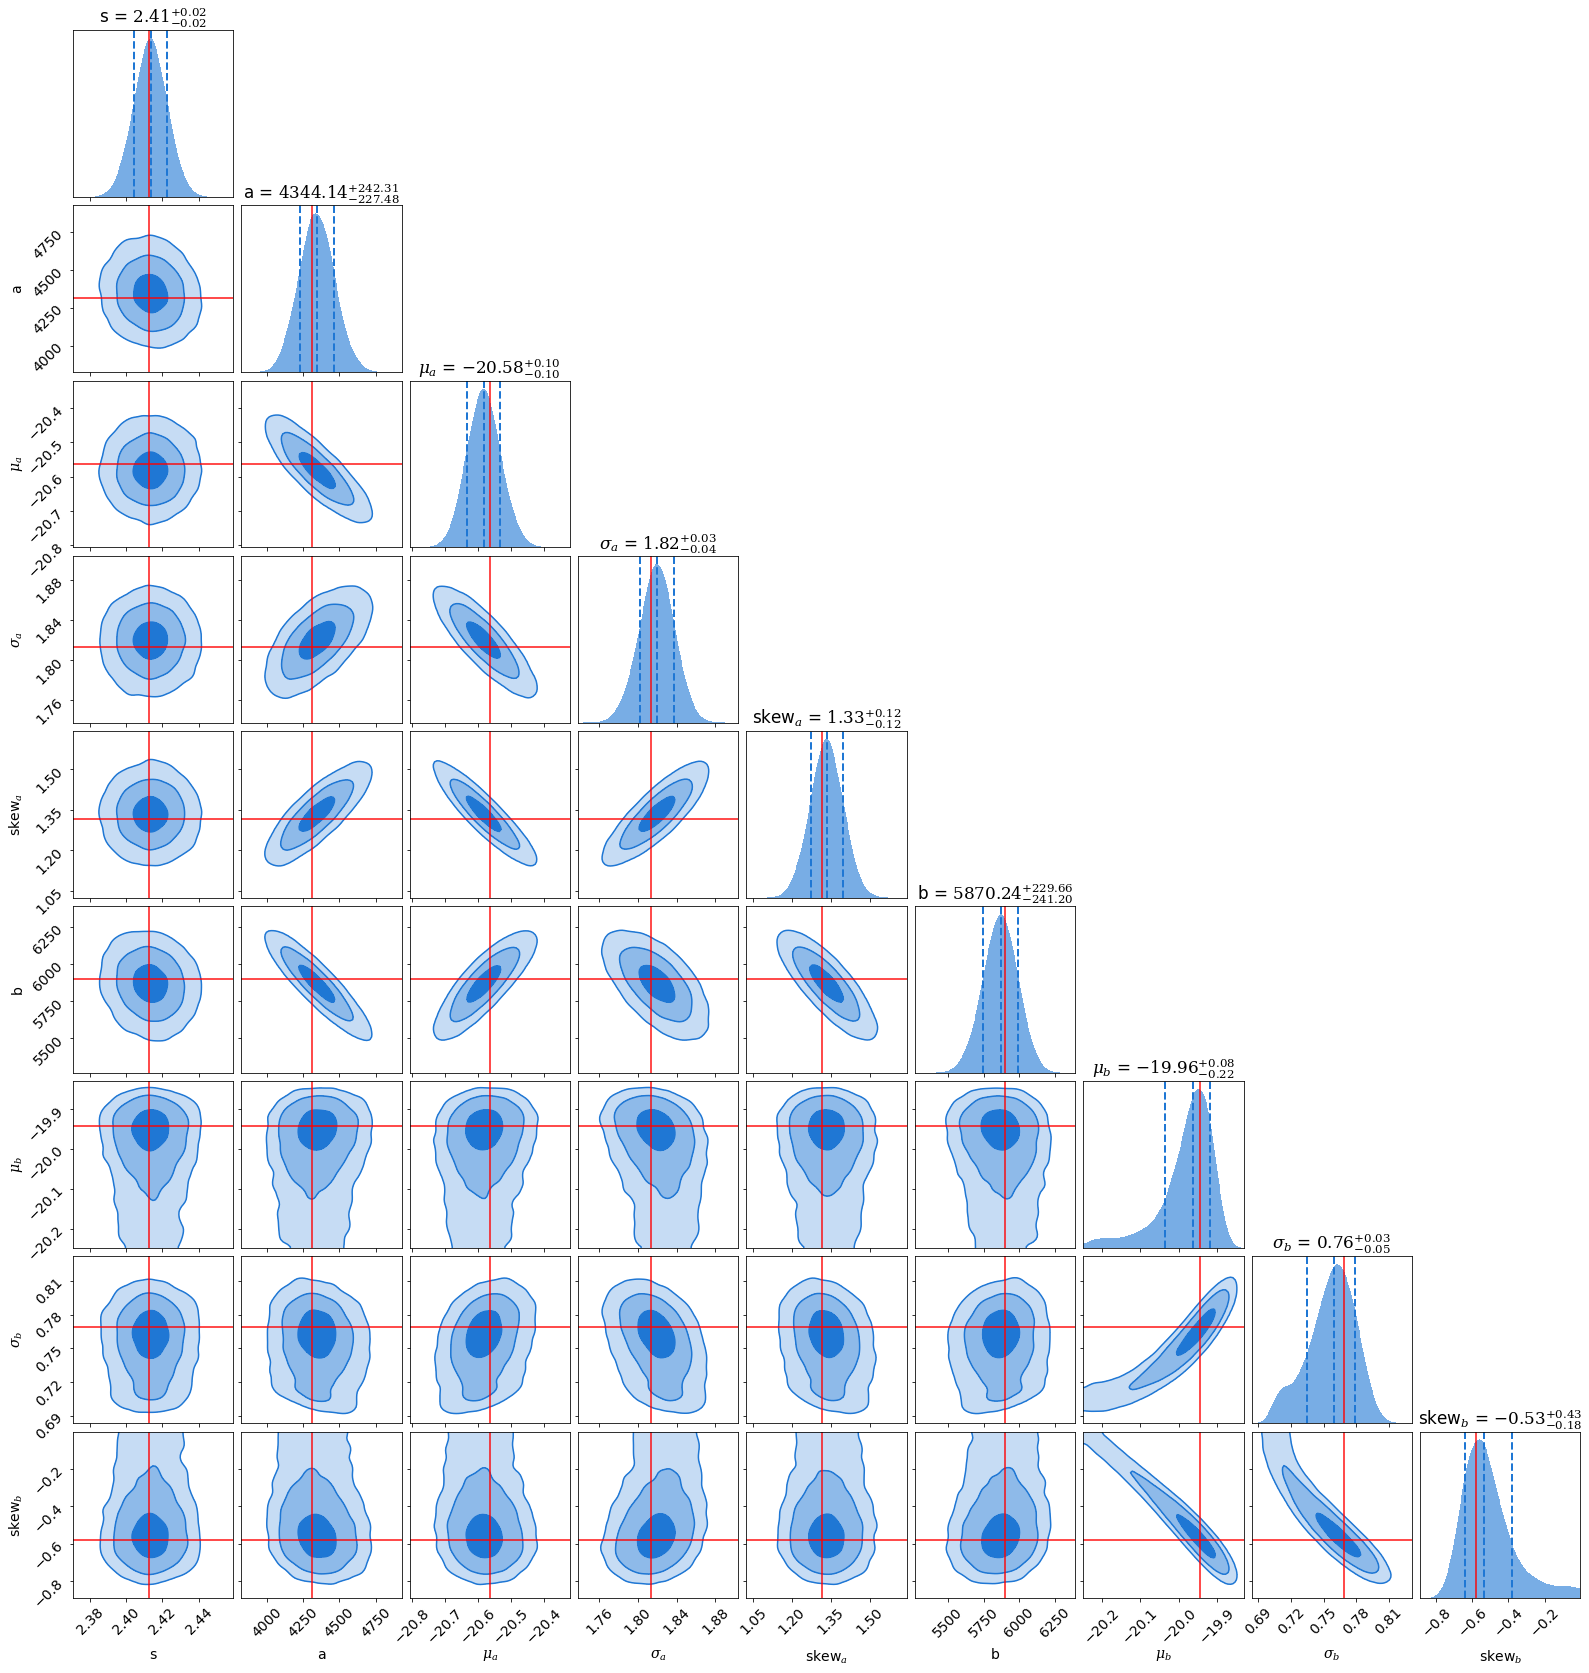

In [19]:
#n_params = len(labels1_uni)
n_params = len(labels1_bi)

fig, axes = dyplot.cornerplot(dres1_V2_rabsmag, smooth=0.03, 
                              labels=labels1_bi, 
                              #labels=labels1_uni, 
                              show_titles=True, 
                              truths=V2_rabsmag_bestfit1.x, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [13]:
lnzM1_V2_rabsmag = dres1_V2_rabsmag.logz[-1]
lnzM1_V2_rabsmag

-1812.438160540364

In [24]:
V2_rabsmag_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_V2_rabsmag.samples, 
                                                    np.exp(dres1_V2_rabsmag.logwt - lnzM1_V2_rabsmag))

V2_rabsmag_bestfit1_dynesty

array([ 2.41347797e+00,  4.34593959e+03, -2.05803759e+01,  1.81953244e+00,
        1.33349017e+00,  5.86877589e+03, -1.99796948e+01,  7.56883810e-01,
       -5.07544939e-01])

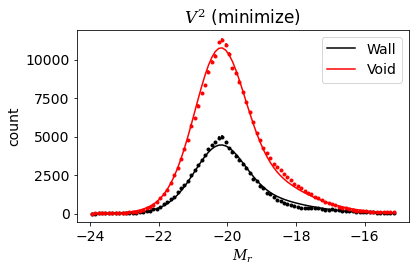

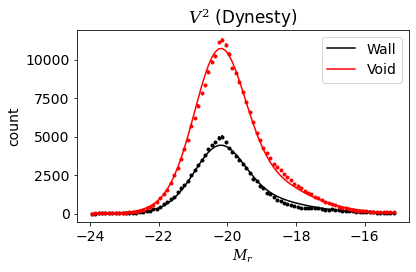

In [25]:
Model_1_plot(V2_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (minimize)')

Model_1_plot(V2_rabsmag_bestfit1_dynesty, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (Dynesty)')

In [31]:
def prior_xform1_uni_VF(u):
    '''
    Priors for the 5 parameters of unimodel M1 for VoidFinder.  Required 
    by the dynesty sampler.  Note that this is customized for the 
    absolute magnitude fitting.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''
    
    '''
    s = uniform(0.01, 5, u[0])
    a = jeffreys(1000, 50000, u[1])
    mu = uniform(-24, -18, u[2])
    sigma = uniform(0.01, 5, u[3])
    skew = uniform(0, 5, u[4])

    return s, a, mu, sigma, skew
    '''
    s = uniform(0.01, 2, u[0])
    
    a = jeffreys(5000, 20000, u[1])
    mu_a = uniform(-22, -20, u[2])
    sigma_a = uniform(0.1, 3, u[3])
    skew_a = uniform(-5, 5, u[4])
    
    b = jeffreys(5000, 30000, u[5])
    mu_b = uniform(-20, -18, u[6])
    sigma_b = uniform(0.01, 3, u[7])
    skew_b = uniform(-5, 5, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [32]:
Model_1_sampler(prior_xform1_uni_VF, 
                rabsmag_NSA[wall_vf], 
                rabsmag_NSA[void_vf], 
                rabsmag_bins, 
                2, 
                '_rabsmag_VoidFinder')

running the nested sampler... this might take from minutes to hours...


37766it [21:51, 28.81it/s, batch: 7 | bound: 1284 | nc: 1 | ncall: 1116046 | eff(%):  3.384 | loglstar: -3854.287 < -3845.330 < -3848.103 | logz: -3888.435 +/-  0.388 | stop:  0.992]       


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_rabsmag_VoidFinder'


In [14]:
temp_infile = open('dynesty_output/sampler_results_model1_rabsmag_VoidFinder.pickle', 
                   'rb')
dres1_VF_rabsmag = pickle.load(temp_infile)
temp_infile.close()

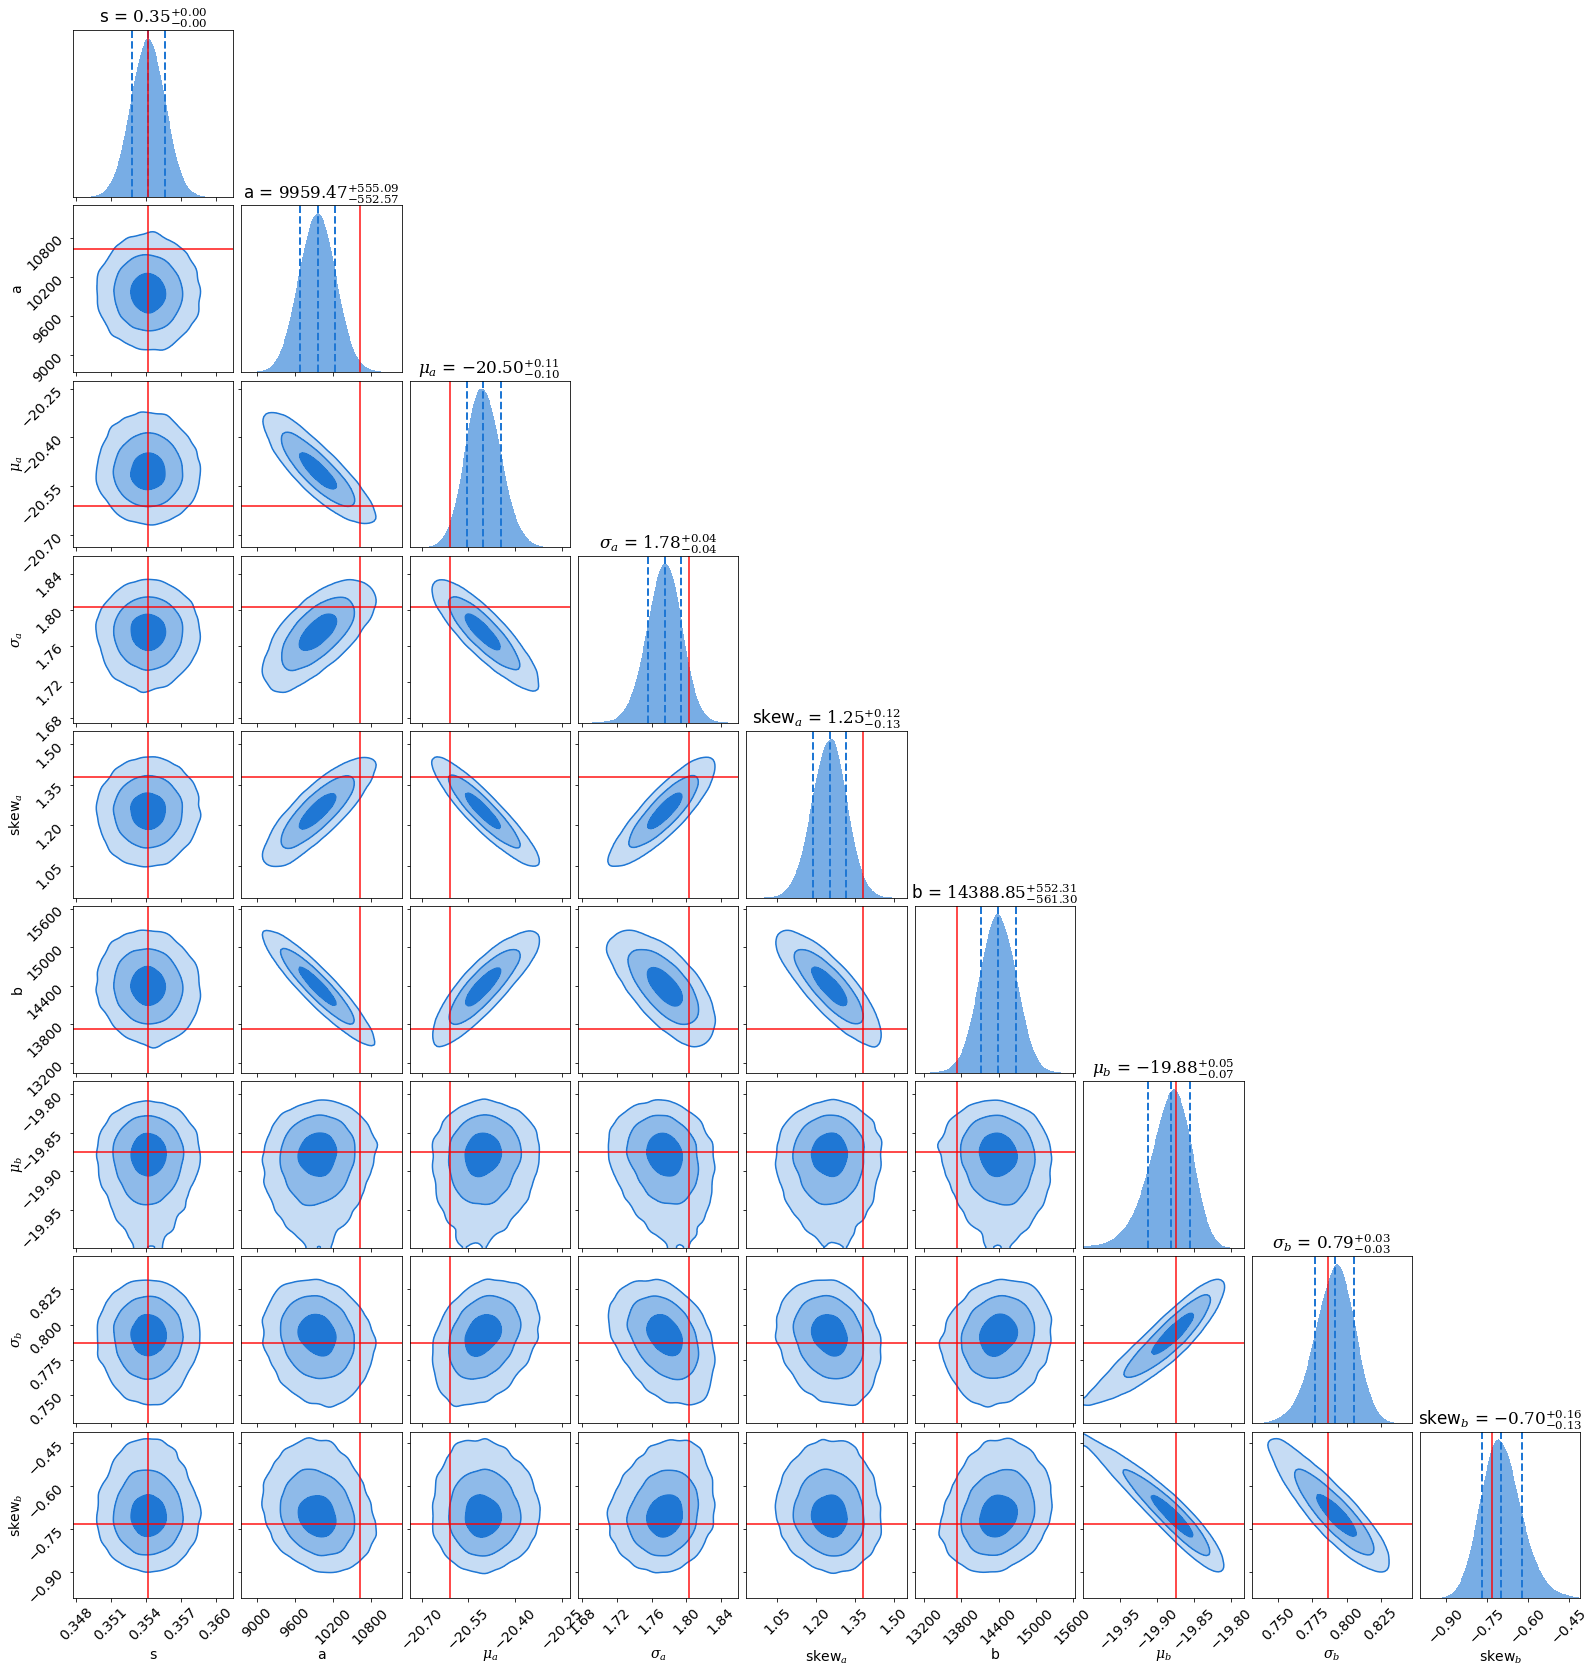

In [36]:
n_params = len(labels1_bi)

fig, axes = dyplot.cornerplot(dres1_VF_rabsmag, smooth=0.03, 
                              labels=labels1_bi, 
                              show_titles=True, 
                              truths=VF_rabsmag_bestfit1.x, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [15]:
lnzM1_VF_rabsmag = dres1_VF_rabsmag.logz[-1]
lnzM1_VF_rabsmag

-3888.4802490403044

In [38]:
VF_rabsmag_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_VF_rabsmag.samples, 
                                                    np.exp(dres1_VF_rabsmag.logwt - lnzM1_VF_rabsmag))

VF_rabsmag_bestfit1_dynesty

array([ 3.54199002e-01,  9.95855560e+03, -2.05014861e+01,  1.77456724e+00,
        1.25116383e+00,  1.43891677e+04, -1.98839454e+01,  7.91079616e-01,
       -6.94389482e-01])

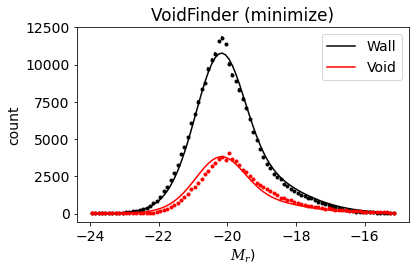

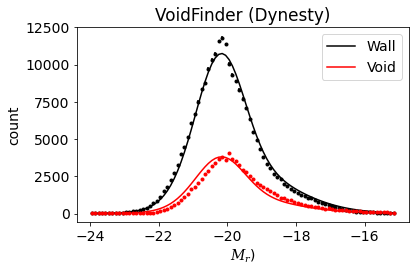

In [39]:
Model_1_plot(VF_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$)', 
             title_text='VoidFinder (minimize)')

Model_1_plot(VF_rabsmag_bestfit1_dynesty, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$)', 
             title_text='VoidFinder (Dynesty)')

## 2-parent model

In [29]:
rabsmag_fit_bounds2 = [[1000, 10000], # a1 ........ Gaussian A amplitude
                       [-22, -16],    # mu_a1 ..... Gaussian A location
                       [0.1, 30],     # sigma_a1 .. Gaussian A scale
                       [0, 30],       # skew_a1 ... Gaussian A skew
                       [1000, 10000], # b1 ........ Gaussian B amplitude
                       [-22, -16],    # mu_b1 ..... Gaussian B location
                       [0.01, 3],     # sigma_b1 .. Gaussian B scale
                       [-10, 10],     # skew_b1 ... Gaussian B skew
                       [1000, 50000], # a2 ........ Gaussian A amplitude
                       [-22, -16],    # mu_a2 ..... Gaussian A location
                       [0.1, 5],      # sigma_a2 .. Gaussian A scale
                       [-5, 5],       # skew_a2 ... Gaussian A skew
                       [1000, 50000], # b2 ........ Gaussian B amplitude
                       [-22, -16],    # mu_b2 ..... Gaussian B location
                       [0.1, 3],      # sigma_b2 .. Gaussian B scale
                       [-5, 5]]       # skew_b2 ... Gaussian B skew

V2_rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA[wall_v2], 
                                  rabsmag_NSA[void_v2], 
                                  rabsmag_bins, 
                                  2)

V2_rabsmag_bestfit2

running minimizer...this might take a few minutes...


      fun: 1150.5610904599896
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.84993179e-02,  9.84618883e-01, -1.18579920e+00, -7.89668780e-01,
       -1.65984538e-03, -3.23689138e+00,  4.30154617e+00,  1.27399745e+00,
        7.84376137e-03,  1.59091074e+00, -2.80335827e+00,  9.48966778e-01,
        2.49636231e-02,  7.19280647e+00, -3.56287730e+00, -7.51401790e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9282
      nit: 426
     njev: 546
   status: 0
  success: True
        x: array([ 3.90243275e+03, -2.10666810e+01,  2.20733803e+00,  4.82810448e+00,
        6.34319831e+03, -1.95974857e+01,  1.06844949e+00, -1.61326283e+00,
        1.30195269e+04, -2.06412425e+01,  1.73439167e+00,  2.58979674e+00,
        1.16371193e+04, -1.97254411e+01,  1.04305687e+00, -1.85267533e+00])

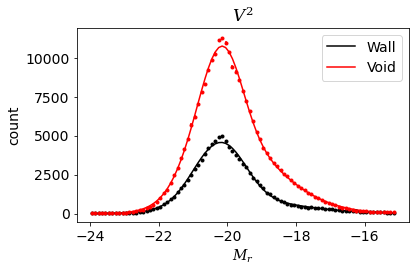

In [30]:
Model_2_plot(V2_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

In [33]:
rabsmag_fit_bounds2 = [[1000, 20000], # a1 ........ Gaussian A amplitude
                       [-22, -16],    # mu_a1 ..... Gaussian A location
                       [0.1, 30],     # sigma_a1 .. Gaussian A scale
                       [0, 30],       # skew_a1 ... Gaussian A skew
                       [1000, 20000], # b1 ........ Gaussian B amplitude
                       [-22, -16],    # mu_b1 ..... Gaussian B location
                       [0.01, 3],     # sigma_b1 .. Gaussian B scale
                       [-10, 10],     # skew_b1 ... Gaussian B skew
                       [1000, 50000], # a2 ........ Gaussian A amplitude
                       [-22, -16],    # mu_a2 ..... Gaussian A location
                       [0.1, 5],      # sigma_a2 .. Gaussian A scale
                       [-5, 5],       # skew_a2 ... Gaussian A skew
                       [1000, 50000], # b2 ........ Gaussian B amplitude
                       [-22, -16],    # mu_b2 ..... Gaussian B location
                       [0.1, 3],      # sigma_b2 .. Gaussian B scale
                       [-5, 5]]       # skew_b2 ... Gaussian B skew

VF_rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA[wall_vf], 
                                  rabsmag_NSA[void_vf], 
                                  rabsmag_bins, 
                                  2)

VF_rabsmag_bestfit2

running minimizer...this might take a few minutes...


      fun: 1154.6455258156948
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00291015,  0.09576978,  2.04909155,  0.04579306,  0.00718443,
        0.04501998,  0.08460575,  0.06484697, -0.0033879 ,  0.08874394,
       -0.01705303,  0.15438673, -0.00977717,  0.07903508,  0.18469564,
        0.14167654])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8993
      nit: 414
     njev: 529
   status: 0
  success: True
        x: array([ 1.33315919e+04, -2.02784799e+01,  6.83656716e-01,  2.67126074e-03,
        1.10134801e+04, -2.07358326e+01,  1.74216894e+00,  1.33311535e+00,
        2.53309529e+03, -2.00236091e+01,  1.98149330e+00,  1.24858787e+00,
        6.11029658e+03, -2.06679014e+01,  1.02845277e+00,  1.36595051e+00])

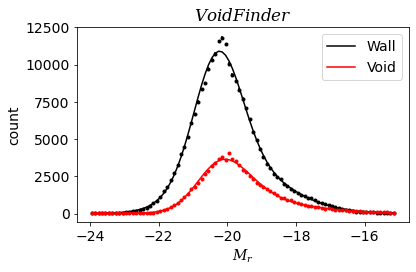

In [34]:
Model_2_plot(VF_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$VoidFinder$')

#### Nested sampling of Likelihood and Priors

##### V$^2$

In [73]:
def prior_xform2_uni_V2(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(1000, 10000, u[0])
    mu_a = uniform(-24, -18, u[1])
    sigma_a = uniform(0.1, 5, u[2])
    skew_a = uniform(0, 5, u[3])

    b = jeffreys(10000, 50000, u[4])
    mu_b = uniform(-24, -18, u[5])
    sigma_b = uniform(0.1, 5, u[6])
    skew_b = uniform(0, 5, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b



def prior_xform2_bi_V2(u):
    '''
    Priors for the 16 parameters of bimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(500, 5000, u[0])
    mu_a1 = uniform(-22, -20.4, u[1])
    sigma_a1 = uniform(0.1, 5, u[2])
    skew_a1 = uniform(-5, 10, u[3])

    b1 = jeffreys(5000, 20000, u[4])
    mu_b1 = uniform(-20.4, -16, u[5])
    sigma_b1 = uniform(0.1, 5, u[6])
    skew_b1 = uniform(-5, 5, u[7])
    
    a2 = jeffreys(5000, 20000, u[8])
    mu_a2 = uniform(-22, -20, u[9])
    sigma_a2 = uniform(0.1, 5, u[10])
    skew_a2 = uniform(0, 5, u[11])

    b2 = jeffreys(5000, 20000, u[12])
    mu_b2 = uniform(-20, -16, u[13])
    sigma_b2 = uniform(0.1, 5, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2


In [74]:
Model_2_sampler(prior_xform2_bi_V2, 
                rabsmag_NSA[wall_v2], 
                rabsmag_NSA[void_v2], 
                rabsmag_bins, 
                2, 
                '_rabsmag_V2')

running the nested sampler... this might take from minutes to hours...


13431it [04:08, 45.64it/s, batch: 0 | bound: 177 | nc: 25 | ncall: 316378 | eff(%):  4.239 | loglstar:   -inf < -2251.109 <    inf | logz: -2282.665 +/-  0.351 | dlogz: 721.700 >  0.010]   /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13618it [04:13, 52.12it/s, batch: 0 | bound: 181 | nc: 25 | ncall: 323829 | eff(%):  4.199 | loglstar:   -inf < -2184.044 <    inf | logz: -2216.383 +/-  0.354 | dlogz: 655.115 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random w

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_rabsmag_V2'


In [75]:
temp_infile = open('dynesty_output/sampler_results_model2_rabsmag_V2.pickle', 'rb')
dres2_V2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

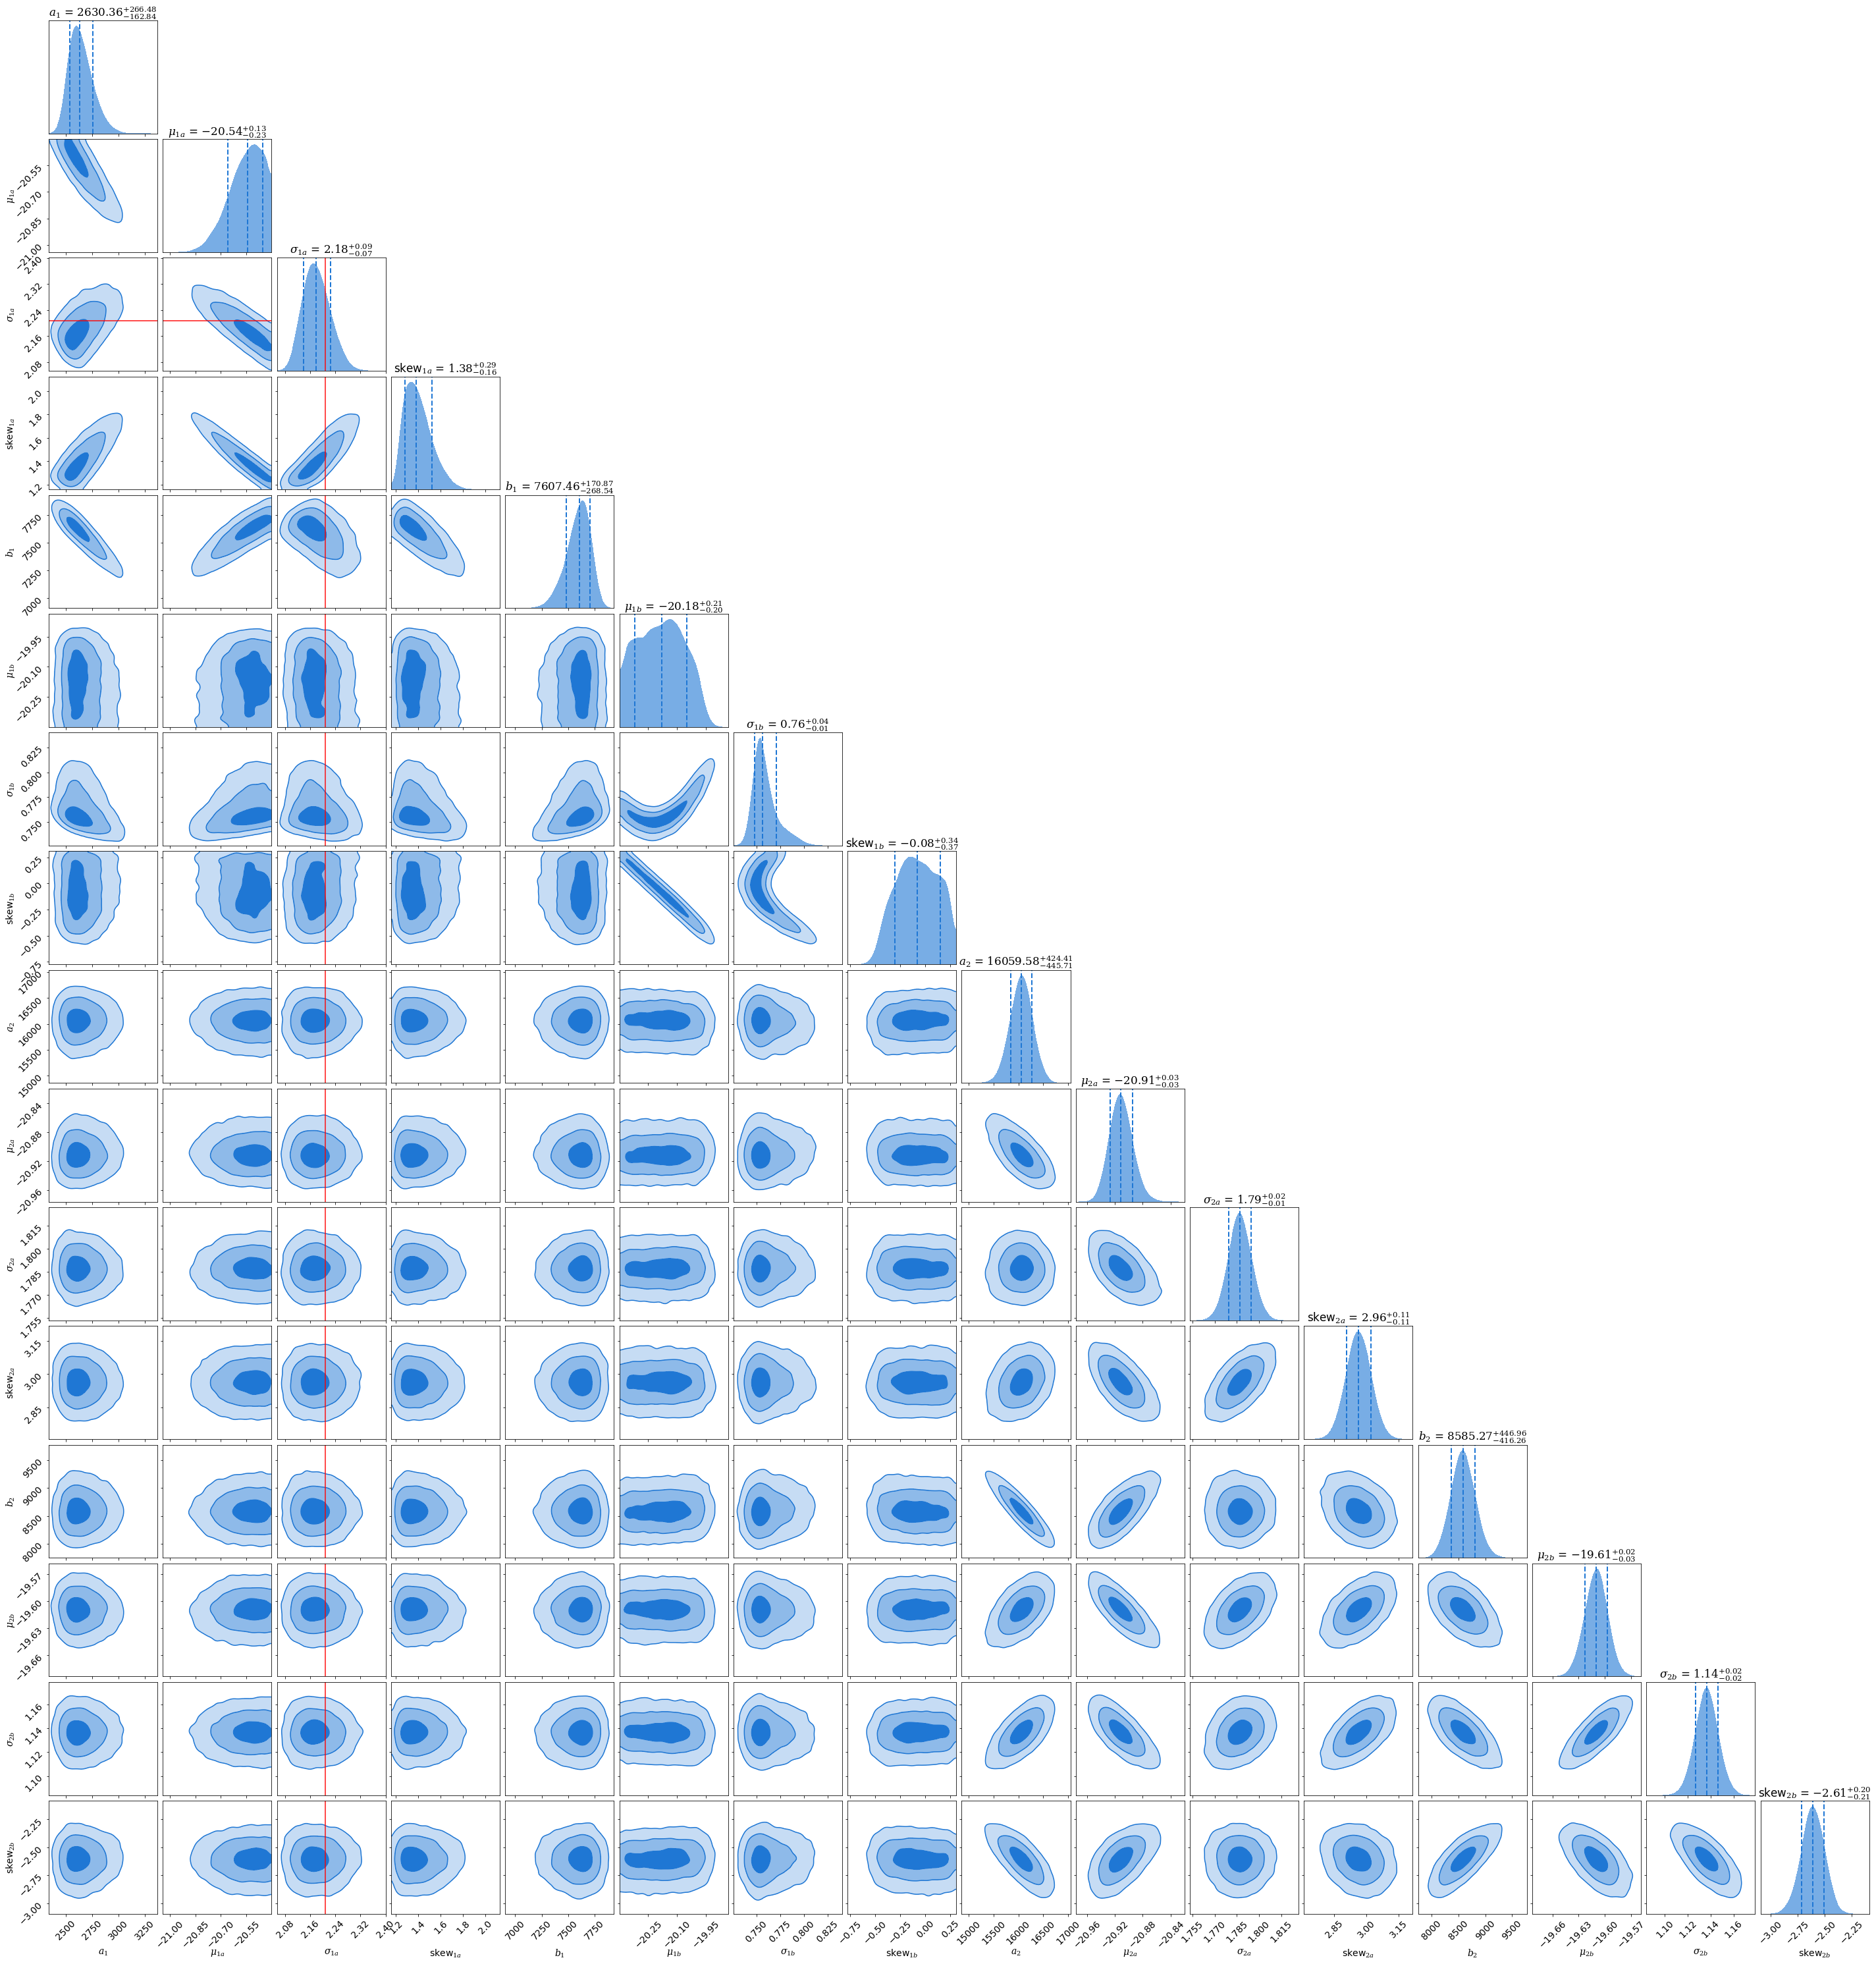

In [76]:
nparams = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_V2_rabsmag, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=V2_rabsmag_bestfit2.x, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(nparams, nparams, figsize=(2.5*nparams, 2.6*nparams)), 
                              color='#1f77d4')

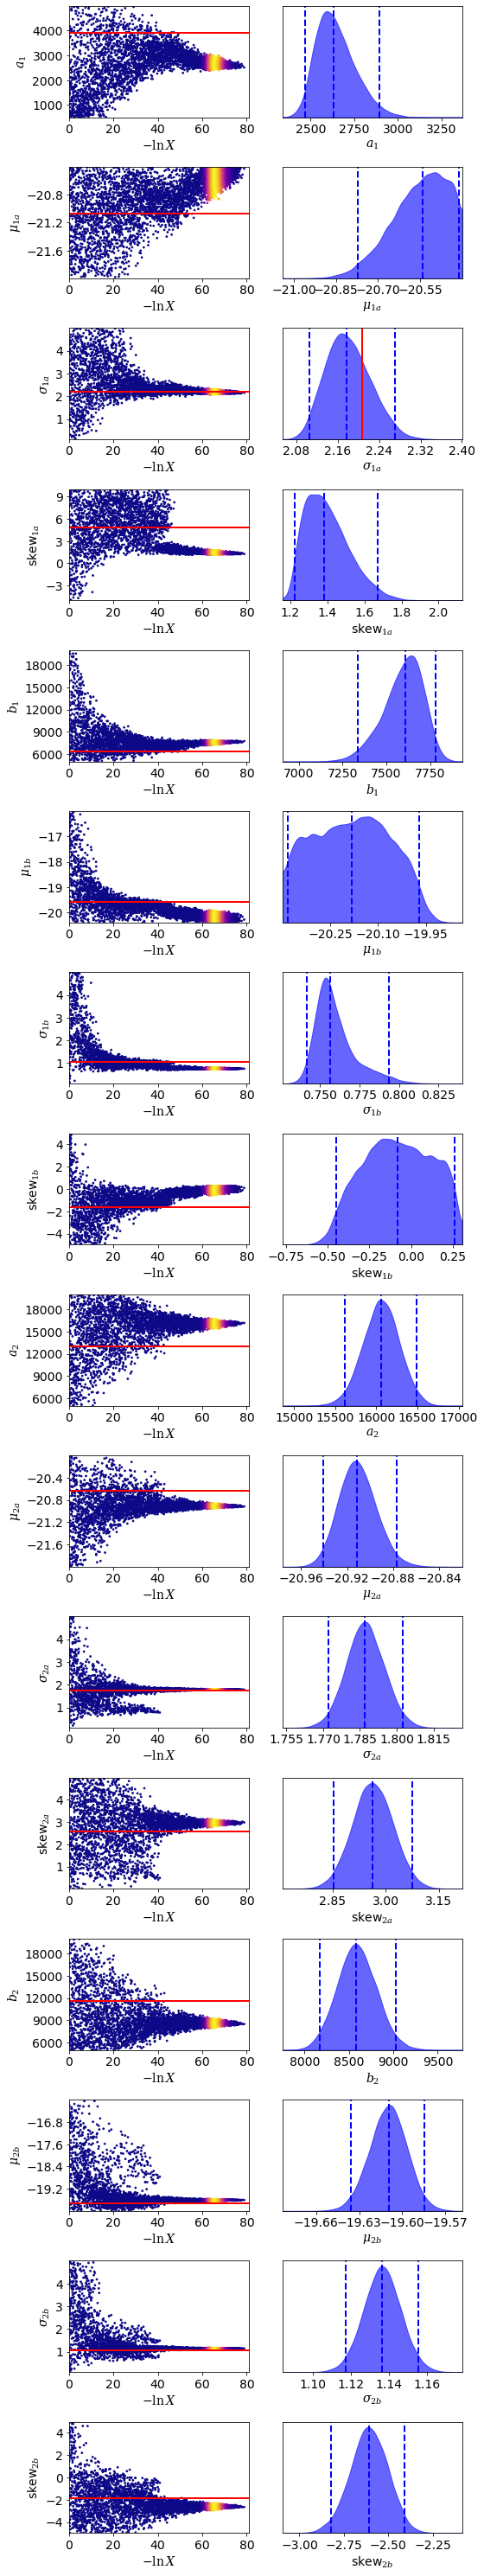

In [77]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_V2_rabsmag, 
                             labels=labels2_bi, 
                             truths=V2_rabsmag_bestfit2.x, 
                             fig=plt.subplots(n_params, 2, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [78]:
lnzM2_V2_rabsmag = dres2_V2_rabsmag.logz[-1]
lnzM2_V2_rabsmag

-1102.2703207303816

In [79]:
V2_rabsmag_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_V2_rabsmag.samples, 
                                                    np.exp(dres2_V2_rabsmag.logwt - lnzM2_V2_rabsmag))

V2_rabsmag_bestfit2_dynesty

array([ 2.64464232e+03, -2.05537547e+01,  2.18054686e+00,  1.39951118e+00,
        7.59320025e+03, -2.01823309e+01,  7.59532826e-01, -8.08749348e-02,
        1.60567925e+04, -2.09108288e+01,  1.78713148e+00,  2.96367946e+00,
        8.58915958e+03, -1.96098541e+01,  1.13650504e+00, -2.60943651e+00])

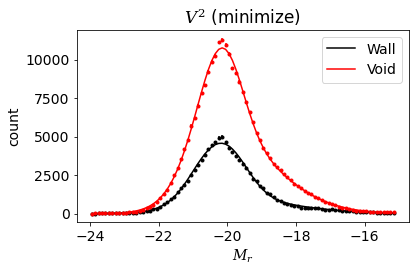

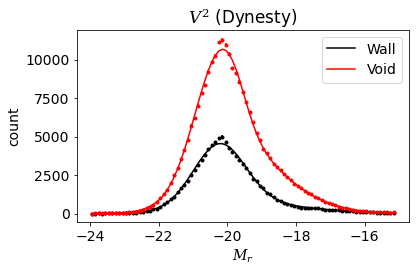

In [80]:
Model_2_plot(V2_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (minimize)')

Model_2_plot(V2_rabsmag_bestfit2_dynesty, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (Dynesty)')

##### VoidFinder

In [86]:
def prior_xform2_uni_VF(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(10000, 50000, u[0])
    mu_a = uniform(-24, -18, u[1])
    sigma_a = uniform(0.1, 5, u[2])
    skew_a = uniform(0, 5, u[3])

    b = jeffreys(500, 20000, u[4])
    mu_b = uniform(-24, -18, u[5])
    sigma_b = uniform(0.1, 5, u[6])
    skew_b = uniform(0, 5, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b


def prior_xform2_bi_VF(u):
    '''
    Priors for the 16 parameters of bimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(5000, 20000, u[0])
    mu_a1 = uniform(-22, -20.5, u[1])
    sigma_a1 = uniform(0.1, 5, u[2])
    skew_a1 = uniform(-5, 5, u[3])

    b1 = jeffreys(5000, 20000, u[4])
    mu_b1 = uniform(-20.5, -16, u[5])
    sigma_b1 = uniform(0.1, 5, u[6])
    skew_b1 = uniform(-5, 5, u[7])
    
    a2 = jeffreys(500, 9000, u[8])
    mu_a2 = uniform(-22, -20.25, u[9])
    sigma_a2 = uniform(0.1, 5, u[10])
    skew_a2 = uniform(0, 5, u[11])

    b2 = jeffreys(500, 9000, u[12])
    mu_b2 = uniform(-20.25, -16, u[13])
    sigma_b2 = uniform(0.1, 5, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [87]:
Model_2_sampler(prior_xform2_bi_VF, 
                rabsmag_NSA[wall_vf], 
                rabsmag_NSA[void_vf], 
                rabsmag_bins, 
                2, 
                '_rabsmag_VoidFinder')

running the nested sampler... this might take from minutes to hours...


1759it [00:11, 52.25it/s, batch: 0 | bound: 0 | nc: 18 | ncall: 17062 | eff(%): 10.016 | loglstar:   -inf < -101988.887 <    inf | logz: -101999.292 +/-  0.203 | dlogz: 66726.407 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
11433it [03:13, 35.81it/s, batch: 0 | bound: 144 | nc: 262 | ncall: 260654 | eff(%):  4.378 | loglstar:   -inf < -3286.481 <    inf | logz: -3315.553 +/-  0.334 | dlogz: 1541.058 >  0.010]/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
12907it [03:46, 24.63it/s, batch: 0 | bound: 169 | nc: 25 | ncall: 305523 | eff(%):  4.218 | loglstar:   -inf

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_rabsmag_VoidFinder'


In [88]:
temp_infile = open('dynesty_output/sampler_results_model2_rabsmag_VoidFinder.pickle', 
                   'rb')
dres2_VF_rabsmag = pickle.load(temp_infile)
temp_infile.close()

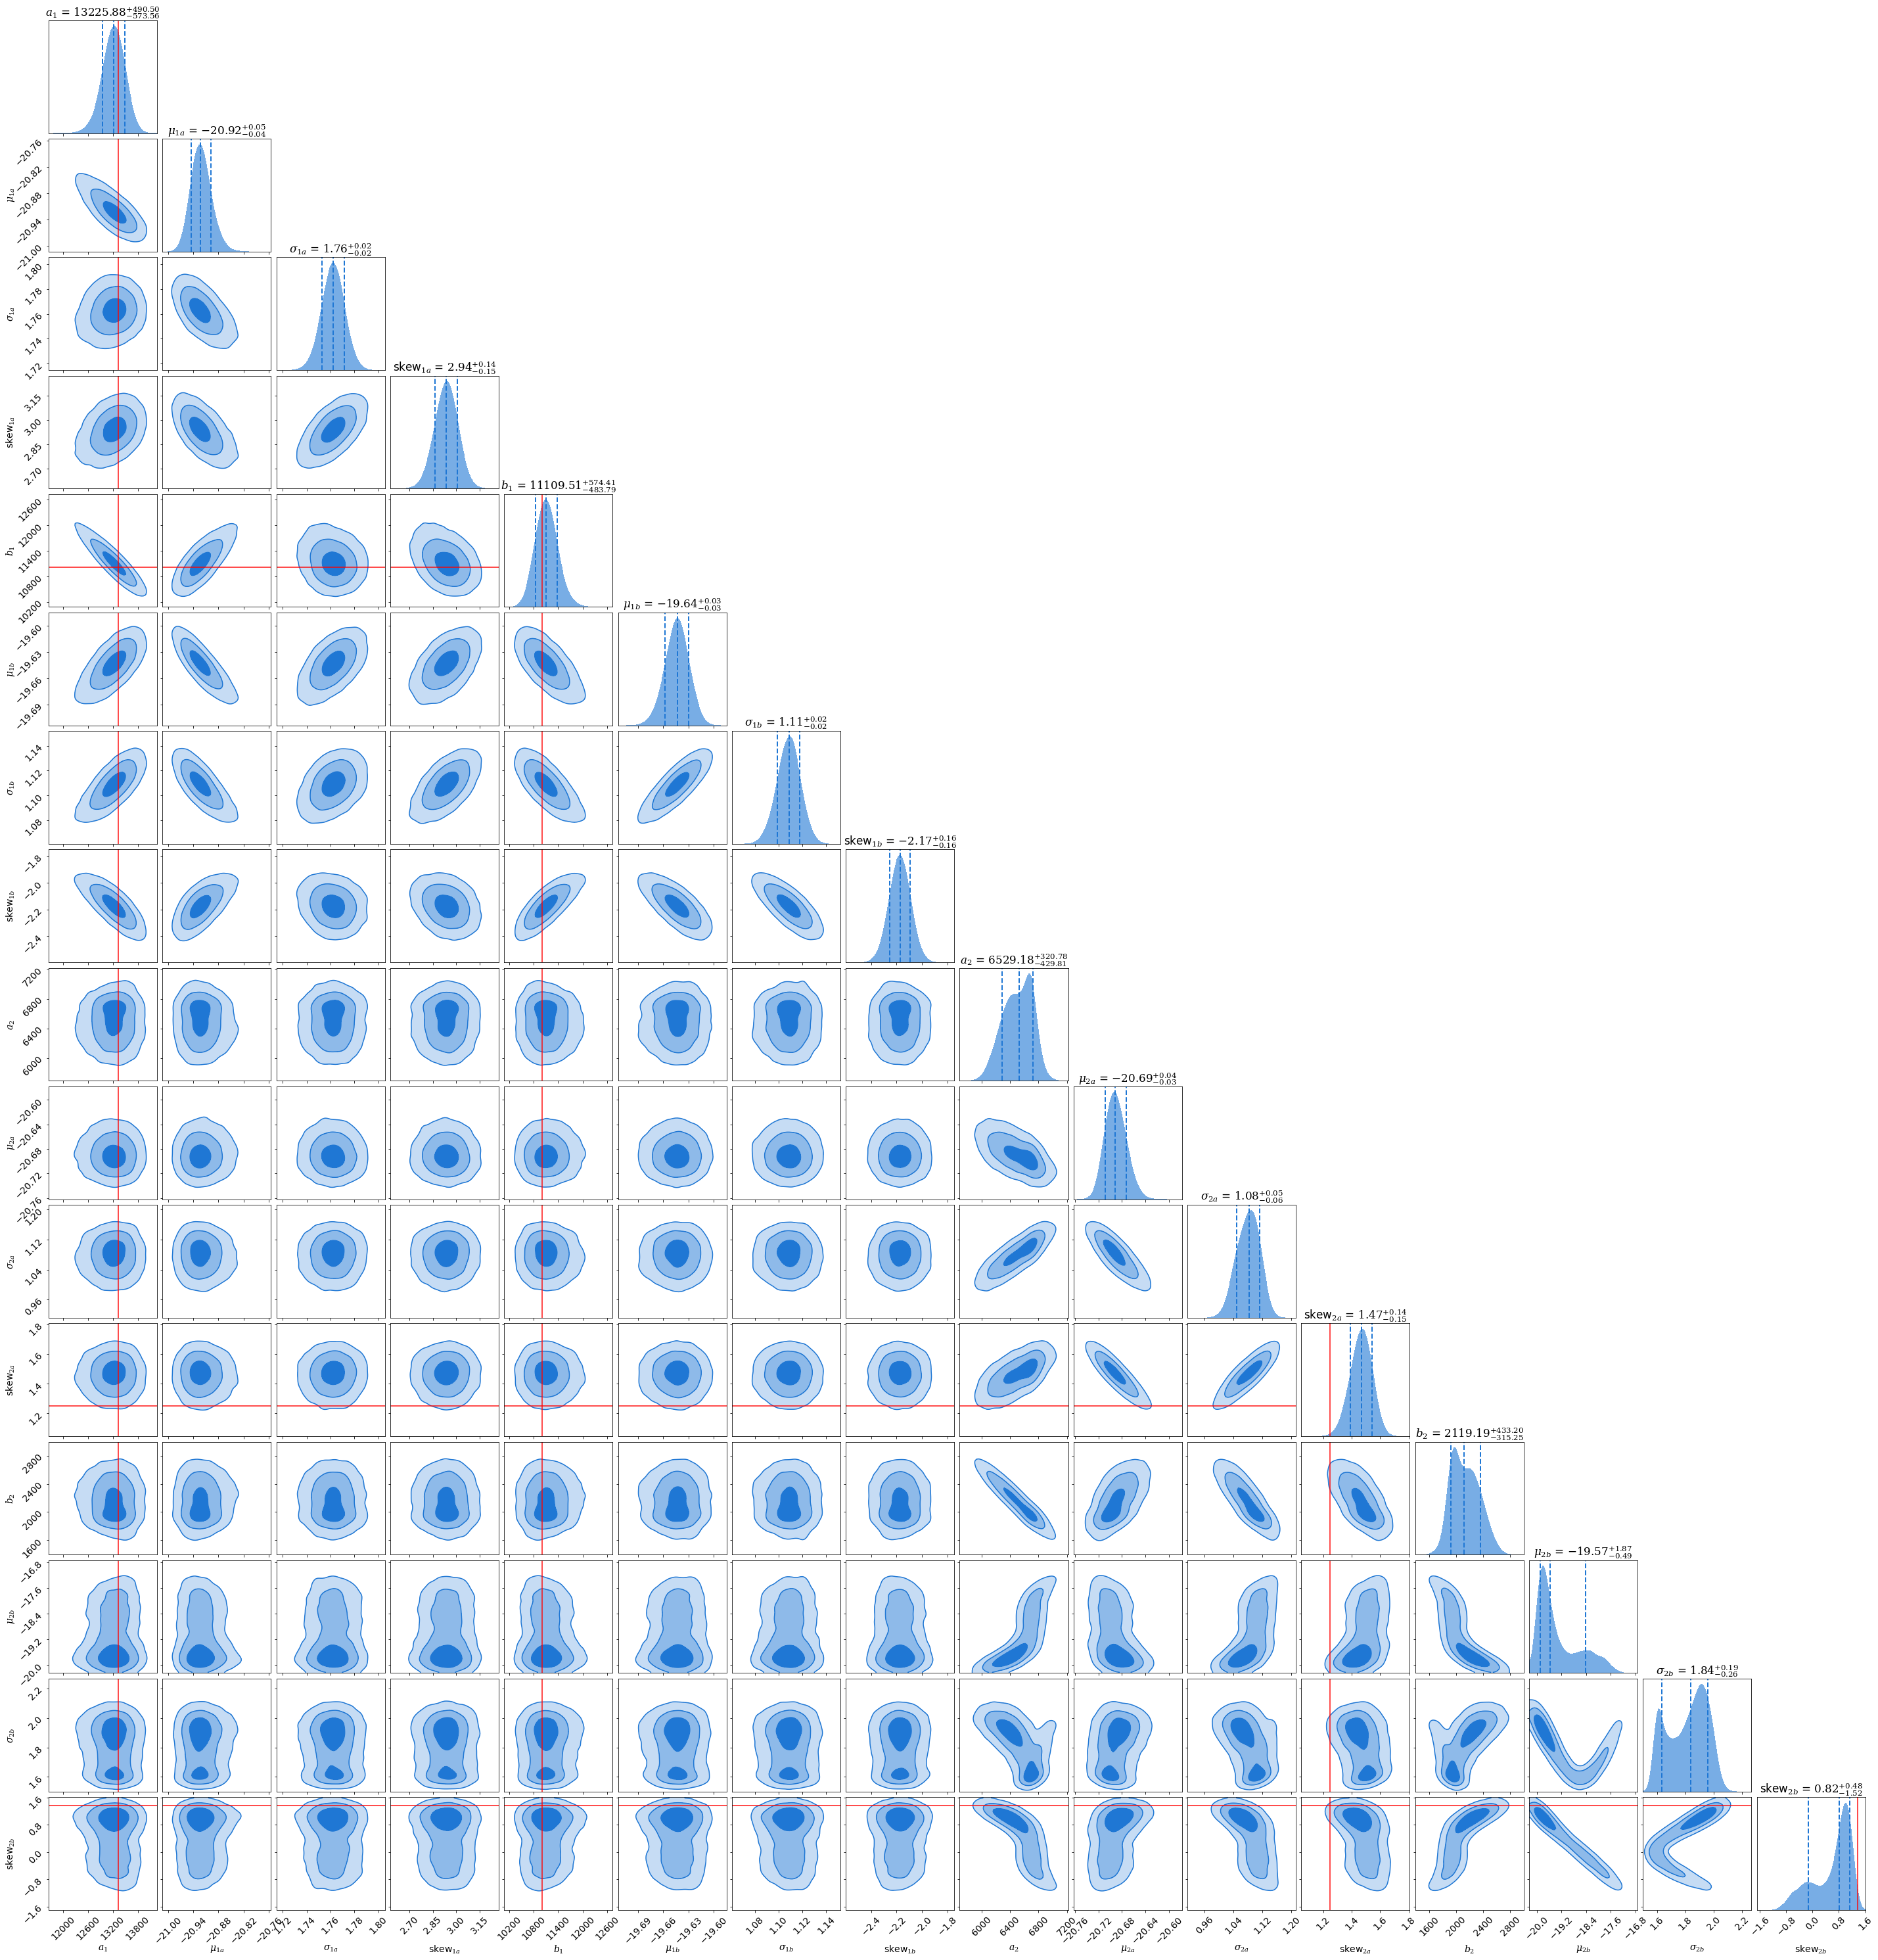

In [89]:
nparams = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_VF_rabsmag, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=VF_rabsmag_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(nparams, nparams, figsize=(2.5*nparams, 2.6*nparams)), 
                              color='#1f77d4')

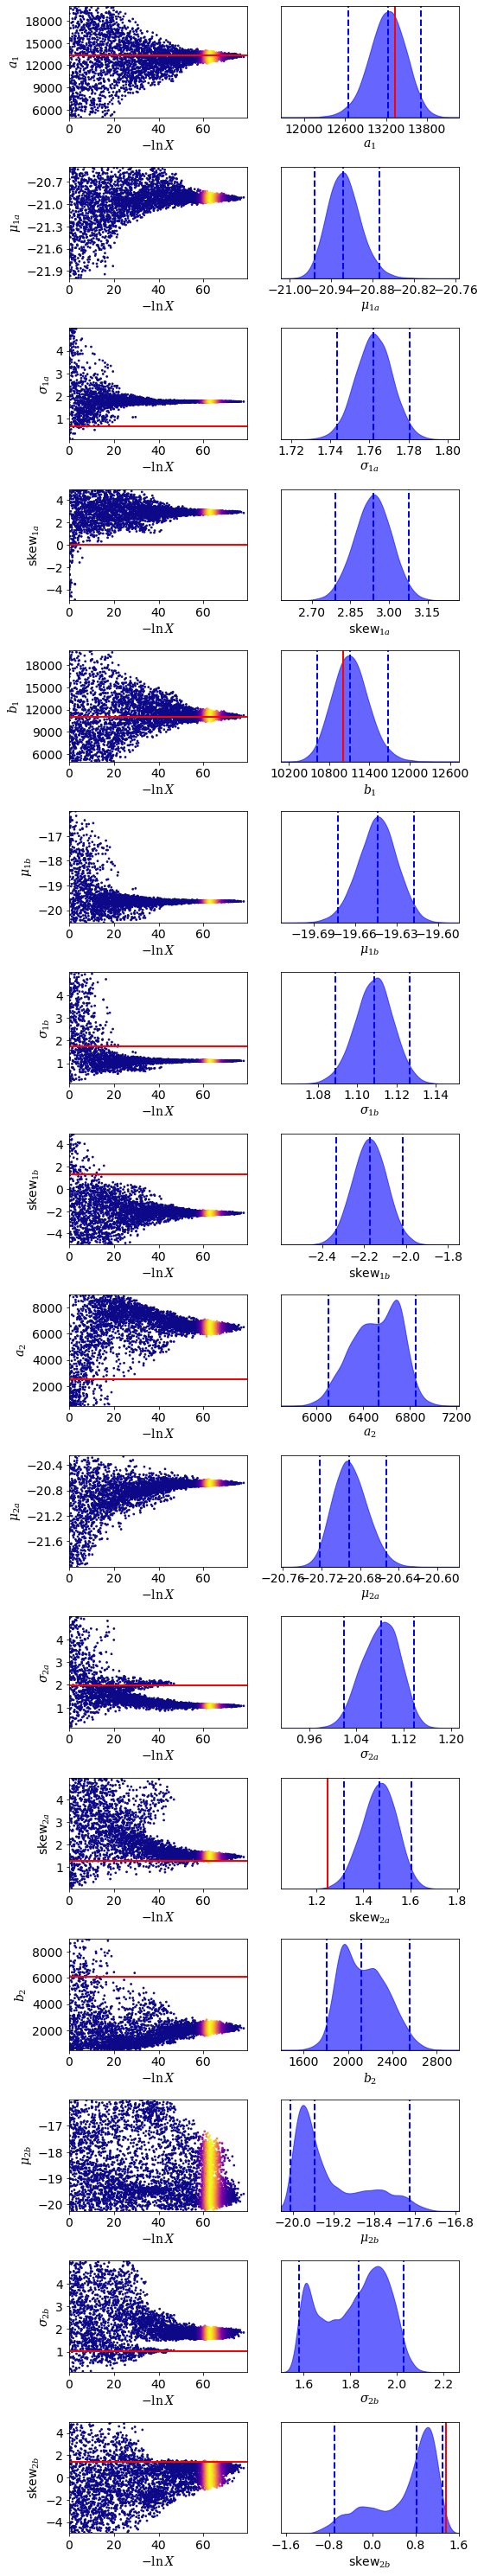

In [90]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_VF_rabsmag, 
                             labels=labels2_bi, 
                             truths=VF_rabsmag_bestfit2.x, 
                             fig=plt.subplots(n_params, 2, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [91]:
lnzM2_VF_rabsmag = dres2_VF_rabsmag.logz[-1]
lnzM2_VF_rabsmag

-1199.2060742546505

In [92]:
VF_rabsmag_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_VF_rabsmag.samples, 
                                                    np.exp(dres2_VF_rabsmag.logwt - lnzM2_VF_rabsmag))

VF_rabsmag_bestfit2_dynesty

array([ 1.32170694e+04, -2.09208499e+01,  1.76222067e+00,  2.93649773e+00,
        1.11187639e+04, -1.96438344e+01,  1.10846668e+00, -2.17373594e+00,
        6.51131925e+03, -2.06901142e+01,  1.08071263e+00,  1.46666751e+00,
        2.13685763e+03, -1.92917382e+01,  1.81366915e+00,  6.01816845e-01])

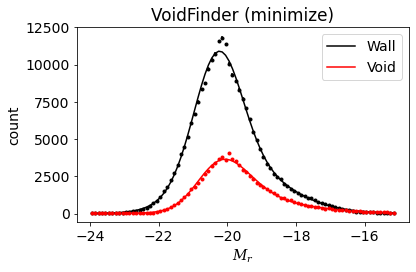

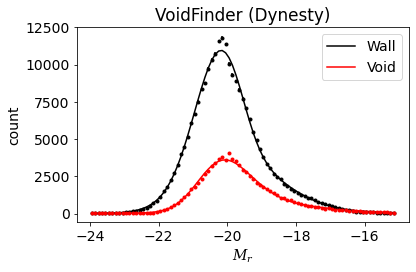

In [93]:
Model_2_plot(VF_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='VoidFinder (minimize)')

Model_2_plot(VF_rabsmag_bestfit2_dynesty, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             2, 
             xlabel_text='$M_r$', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [94]:
lnB12_V2_rabsmag = lnzM1_V2_rabsmag - lnzM2_V2_rabsmag

B12_V2_rabsmag = np.exp(lnB12_V2_rabsmag)

#print('V2 Mr: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_rabsmag, np.log10(B12_V2_rabsmag)))
print('V2 Mr: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_V2_rabsmag, lnB12_V2_rabsmag*np.log10(np.exp(1))))

V2 Mr: B12 = 3.78e-309; log(B12) = -308.422


In [95]:
lnB12_VF_rabsmag = lnzM1_VF_rabsmag - lnzM2_VF_rabsmag

B12_VF_rabsmag = np.exp(lnB12_VF_rabsmag)

print('VoidFinder Mr: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_rabsmag, 
                                                              lnB12_VF_rabsmag*np.log10(np.exp(1))))

VoidFinder Mr: B12 = 0; log(B12) = -1167.937


So both $V^2$ and VoidFinder overwhelmingly favor model $\mathcal{M}_2$, in which the two data sets come from different parent distributions.